In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Correction - ConvNext Frame Predictor

In [2]:
import glob
import os
model_paths = sorted(glob.glob('../models/ConvNextFramePredictor_v*'))

dfs = []
for i, model_path in enumerate(model_paths):
    print(os.path.basename(model_path))
    dfs.append(pd.read_csv(f'{model_path}/prediction_statistics.csv'))

df_all = pd.concat(dfs, ignore_index=True);

ConvNextFramePredictor_v1
ConvNextFramePredictor_v2
ConvNextFramePredictor_v3


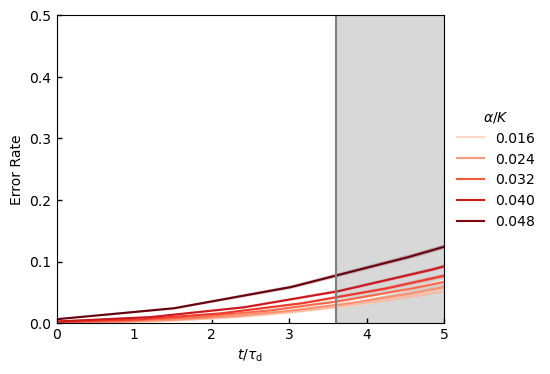

In [3]:
# Seaborn for accuracy plotting as a function of activity
# Short term accuracy is still consistent

import seaborn as sns

df_all = df_all.replace(np.inf, np.nan).dropna()
df_all['error_rate'] = 1 - df_all['dot_product']
    

fig, ax = plt.subplots(1, 1, figsize=(5,4))
eta = 0.33
df_all['t_a'] = df_all['t'] / (eta / df_all['z'])
df_all['z'] = np.round(df_all['z'], decimals=3)
sns.lineplot(
    data=df_all,
    x='t_a',
    y='error_rate',
    hue='z',
    palette='Reds',
    ax=ax,
    legend=True
)
ax.legend(title='$\\alpha / K$', framealpha=0, loc='center left', bbox_to_anchor=[1, 0.5])
ax.set_xlabel(r'$t / \tau_{\mathregular{d}}$')
ax.set_xlim([0, 5])
ax.set_ylim([0, 0.5])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_ylabel('Error Rate')
ax.tick_params(which='both', width=1, direction='in')

tau_l = 3.6 # Lyapunov time reported in paper
ax.axvline(tau_l, color='grey')
ax.fill_betweenx(ax.get_ylim(), tau_l, 5, color='grey', alpha=0.3)

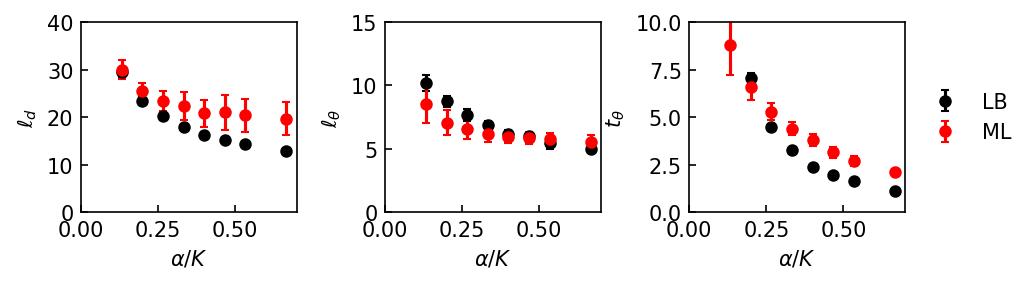

In [4]:
# Updated models
# Spatial behavior is largely the same as before
# Temporal dynamics are *much* more consistent

df_all['l_defect_LB'] = 200/np.sqrt(df_all['n_defects_LB'])
df_all['l_defect_ML'] = 200/np.sqrt(df_all['n_defects_ML'])
df_all = df_all.replace(np.inf, np.nan)

df_all_grouped = df_all.groupby('z').agg(['mean', 'std']).reset_index()
df_all_grouped['zk'] = df_all_grouped['z'] / 0.075 # Divide by elastic modulus
df_all_grouped['tcT_LB'] /= 3 #Divide by tau_LC
df_all_grouped['tcT_ML'] /= 3 #Divide by tau_LC

fig, ax = plt.subplots(1, 3, dpi=150, figsize=(7,2))
kwargs = dict(linestyle='', marker='o', markersize=5, capsize=2)
ax[0].errorbar(df_all_grouped['zk'], df_all_grouped['l_defect_LB']['mean'], yerr=df_all_grouped['l_defect_LB']['std'],
               color='black', label='LB', **kwargs)
ax[0].errorbar(df_all_grouped['zk'], df_all_grouped['l_defect_ML']['mean'], yerr=df_all_grouped['l_defect_ML']['std'],
               color='red', label='ML', **kwargs)

ax[1].errorbar(df_all_grouped['zk'], df_all_grouped['lc_LB']['mean'], yerr=df_all_grouped['lc_LB']['std'],
               color='black', label='LB', **kwargs)
ax[1].errorbar(df_all_grouped['zk'], df_all_grouped['lc_ML']['mean'], yerr=df_all_grouped['lc_ML']['std'],
               color='red', label='ML', **kwargs)

ax[2].errorbar(df_all_grouped['zk'], df_all_grouped['tcT_LB']['mean'], yerr=df_all_grouped['tcT_LB']['std'],
               color='black', label='LB', **kwargs)
ax[2].errorbar(df_all_grouped['zk'], df_all_grouped['tcT_ML']['mean'], yerr=df_all_grouped['tcT_ML']['std'],
               color='red', label='ML', **kwargs)

ax[0].set(xlabel='$\\alpha/K$', ylabel='$\\ell_{d}$', xlim=[0, 0.7], ylim=[0,40])
ax[1].set(xlabel='$\\alpha/K$', ylabel='$\\ell_{\\theta}$', xlim=[0, 0.7], ylim=[0,15])
ax[2].set(xlabel='$\\alpha/K$', ylabel='$t_{\\theta}$', xlim=[0, 0.7], ylim=[0, 10])

ax[0].tick_params(which='both', direction='in')
ax[1].tick_params(which='both', direction='in')
ax[2].tick_params(which='both', direction='in')
ax[2].legend(loc='center left', bbox_to_anchor=[1, 0.5], framealpha=0)

plt.tight_layout()

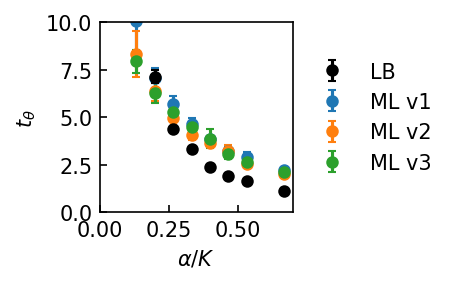

In [5]:
def load_and_process_df(path):
    df = pd.read_csv(path)
    df['l_defect_LB'] = 200/np.sqrt(df['n_defects_LB'])
    df['l_defect_ML'] = 200/np.sqrt(df['n_defects_ML'])
    df = df.replace(np.inf, np.nan)
    
    df_grouped = df.groupby('z').agg(['mean', 'std']).reset_index()
    df_grouped['zk'] = df_all_grouped['z'] / 0.075 # Divide by elastic modulus
    df_grouped['tcT_LB'] /= 3 #Divide by tau_LC
    df_grouped['tcT_ML'] /= 3 #Divide by tau_LC

    return df_grouped

# Consistency in time dynamics is way better and all models reach similar loss
df1 = load_and_process_df('../models/ConvNextFramePredictor_v1/prediction_statistics.csv')
df2 = load_and_process_df('../models/ConvNextFramePredictor_v2/prediction_statistics.csv')
df3 = load_and_process_df('../models/ConvNextFramePredictor_v3/prediction_statistics.csv')

fig, ax = plt.subplots(1, 1, dpi=150, figsize=(3, 2))

ax.errorbar(df1['zk'], df1[('tcT_LB', 'mean')], yerr=df1[('tcT_LB','std')],
               color='black', label='LB', **kwargs, zorder=10)
ax.errorbar(df1['zk'], df1[('tcT_ML', 'mean')], yerr=df1[('tcT_ML','std')],
               label='ML v1', **kwargs)
ax.errorbar(df2['zk'], df2[('tcT_ML', 'mean')], yerr=df2[('tcT_ML','std')],
               label='ML v2', **kwargs)
ax.errorbar(df3['zk'], df3[('tcT_ML', 'mean')], yerr=df3[('tcT_ML','std')],
               label='ML v3', **kwargs)

ax.set(xlabel='$\\alpha/K$', ylabel='$t_{\\theta}$', xlim=[0, 0.7], ylim=[0, 10])
ax.tick_params(which='both', direction='in')
ax.legend(loc='center left', bbox_to_anchor=[1, 0.5], framealpha=0)

plt.tight_layout()

# Original frame predictor

In [6]:
import glob
import os
model_paths = sorted(glob.glob('../models/ResidualFramePredictor_v*'))

dfs = []
for i, model_path in enumerate(model_paths):
    print(os.path.basename(model_path))
    dfs.append(pd.read_csv(f'{model_path}/prediction_statistics.csv'))

df_all = pd.concat(dfs, ignore_index=True);

ResidualFramePredictor_v1
ResidualFramePredictor_v2
ResidualFramePredictor_v3
ResidualFramePredictor_v4
ResidualFramePredictor_v5
ResidualFramePredictor_v6
ResidualFramePredictor_v7
ResidualFramePredictor_v8


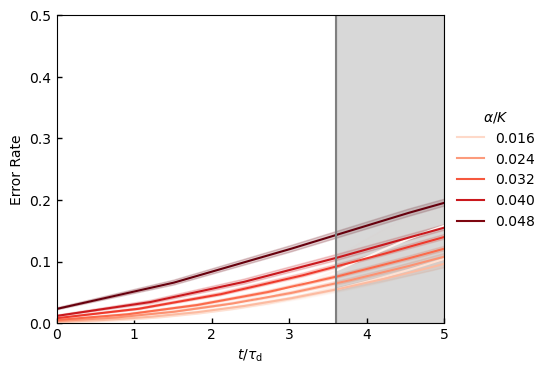

In [7]:
# Seaborn for accuracy plotting as a function of activity
# The accuracy plots are reasonable - the models do okay in the short-term
import seaborn as sns

df_all = df_all.replace(np.inf, np.nan).dropna()
df_all['error_rate'] = 1 - df_all['dot_product']
    

fig, ax = plt.subplots(1, 1, figsize=(5,4))
eta = 0.33
df_all['t_a'] = df_all['t'] / (eta / df_all['z'])
df_all['z'] = np.round(df_all['z'], decimals=3)
sns.lineplot(
    data=df_all,
    x='t_a',
    y='error_rate',
    hue='z',
    palette='Reds',
    ax=ax,
    legend=True
)
ax.legend(title='$\\alpha / K$', framealpha=0, loc='center left', bbox_to_anchor=[1, 0.5])
ax.set_xlabel(r'$t / \tau_{\mathregular{d}}$')
ax.set_xlim([0, 5])
ax.set_ylim([0, 0.5])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_ylabel('Error Rate')
ax.tick_params(which='both', width=1, direction='in')

tau_l = 3.6 # Lyapunov time reported in paper
ax.axvline(tau_l, color='grey')
ax.fill_betweenx(ax.get_ylim(), tau_l, 5, color='grey', alpha=0.3)

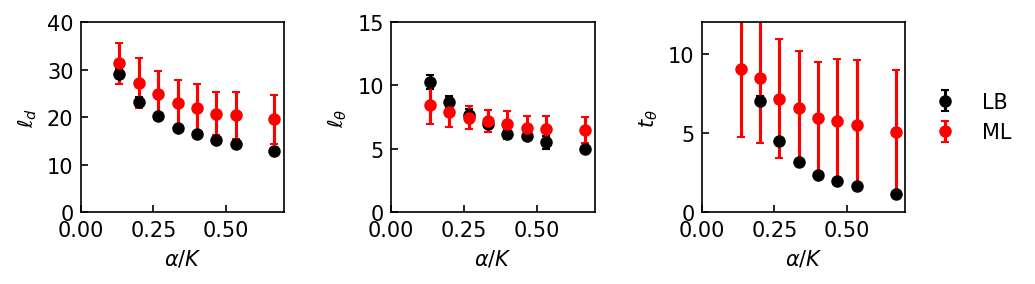

In [8]:
# Residual Frame Predictor
# Spatial behavior seems consistent across models 
#    - this is largely controlled by sharpening algorithm though...
# Temporal behavior is wildly inconsistent across models though!

df_all['l_defect_LB'] = 200/np.sqrt(df_all['n_defects_LB'])
df_all['l_defect_ML'] = 200/np.sqrt(df_all['n_defects_ML'])
df_all = df_all.replace(np.inf, np.nan)

df_all_grouped = df_all.groupby('z').agg(['mean', 'std']).reset_index()
df_all_grouped['zk'] = df_all_grouped['z'] / 0.075 # Divide by elastic modulus
df_all_grouped['tcT_LB'] /= 3 #Divide by tau_LC
df_all_grouped['tcT_ML'] /= 3 #Divide by tau_LC

fig, ax = plt.subplots(1, 3, dpi=150, figsize=(7,2))
kwargs = dict(linestyle='', marker='o', markersize=5, capsize=2)
ax[0].errorbar(df_all_grouped['zk'], df_all_grouped['l_defect_LB']['mean'], yerr=df_all_grouped['l_defect_LB']['std'],
               color='black', label='LB', **kwargs)
ax[0].errorbar(df_all_grouped['zk'], df_all_grouped['l_defect_ML']['mean'], yerr=df_all_grouped['l_defect_ML']['std'],
               color='red', label='ML', **kwargs)

ax[1].errorbar(df_all_grouped['zk'], df_all_grouped['lc_LB']['mean'], yerr=df_all_grouped['lc_LB']['std'],
               color='black', label='LB', **kwargs)
ax[1].errorbar(df_all_grouped['zk'], df_all_grouped['lc_ML']['mean'], yerr=df_all_grouped['lc_ML']['std'],
               color='red', label='ML', **kwargs)

ax[2].errorbar(df_all_grouped['zk'], df_all_grouped['tcT_LB']['mean'], yerr=df_all_grouped['tcT_LB']['std'],
               color='black', label='LB', **kwargs)
ax[2].errorbar(df_all_grouped['zk'], df_all_grouped['tcT_ML']['mean'], yerr=df_all_grouped['tcT_ML']['std'],
               color='red', label='ML', **kwargs)

ax[0].set(xlabel='$\\alpha/K$', ylabel='$\\ell_{d}$', xlim=[0, 0.7], ylim=[0,40])
ax[1].set(xlabel='$\\alpha/K$', ylabel='$\\ell_{\\theta}$', xlim=[0, 0.7], ylim=[0,15])
ax[2].set(xlabel='$\\alpha/K$', ylabel='$t_{\\theta}$', xlim=[0, 0.7], ylim=[0, 12])

ax[0].tick_params(which='both', direction='in')
ax[1].tick_params(which='both', direction='in')
ax[2].tick_params(which='both', direction='in')
ax[2].legend(loc='center left', bbox_to_anchor=[1, 0.5], framealpha=0)

plt.tight_layout()

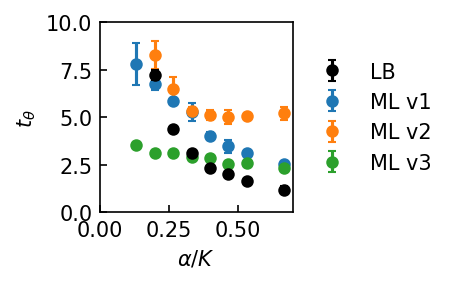

In [9]:
# interesting -- model loss does not correlate with capturing activity-dependent dynamics

def load_and_process_df(path):
    df = pd.read_csv(path)
    df['l_defect_LB'] = 200/np.sqrt(df['n_defects_LB'])
    df['l_defect_ML'] = 200/np.sqrt(df['n_defects_ML'])
    df = df.replace(np.inf, np.nan)
    
    df_grouped = df.groupby('z').agg(['mean', 'std']).reset_index()
    df_grouped['zk'] = df_all_grouped['z'] / 0.075 # Divide by elastic modulus
    df_grouped['tcT_LB'] /= 3 #Divide by tau_LC
    df_grouped['tcT_ML'] /= 3 #Divide by tau_LC

    return df_grouped

# loss is decent - loss = 0.053
# dynamics are activity-dependent
df1 = load_and_process_df('../models/ResidualFramePredictor_v1/prediction_statistics.csv')

# loss is bad - loss = 0.073
# dynamics are activity dependent but misses high-activity
df2 = load_and_process_df('../models/ResidualFramePredictor_v2/prediction_statistics.csv')

# loss is good - loss = 0.040
# dynamics are *not* activity dependent
df3 = load_and_process_df('../models/ResidualFramePredictor_v3/prediction_statistics.csv')

fig, ax = plt.subplots(1, 1, dpi=150, figsize=(3, 2))

ax.errorbar(df1['zk'], df1[('tcT_LB', 'mean')], yerr=df1[('tcT_LB','std')],
               color='black', label='LB', **kwargs, zorder=10)
ax.errorbar(df1['zk'], df1[('tcT_ML', 'mean')], yerr=df1[('tcT_ML','std')],
               label='ML v1', **kwargs)
ax.errorbar(df2['zk'], df2[('tcT_ML', 'mean')], yerr=df2[('tcT_ML','std')],
               label='ML v2', **kwargs)
ax.errorbar(df3['zk'], df3[('tcT_ML', 'mean')], yerr=df3[('tcT_ML','std')],
               label='ML v3', **kwargs)

ax.set(xlabel='$\\alpha/K$', ylabel='$t_{\\theta}$', xlim=[0, 0.7], ylim=[0, 10])
ax.tick_params(which='both', direction='in')
ax.legend(loc='center left', bbox_to_anchor=[1, 0.5], framealpha=0)

plt.tight_layout()